In [1]:
import torch
import torch.nn as nn
import numpy as np
from myutils.common import yaml_util
from utils import module_util, net_measure_util

In [2]:
config_file_path = '../config/densenet169.yaml'
config = yaml_util.load_yaml_file(config_file_path)
model = module_util.get_model(config, 'cpu')

In [3]:
modules = list()
module_util.extract_all_child_modules(model, modules, extract_designed_module=False)

In [4]:
for i, module in enumerate(modules):
    print(i, type(module).__name__)

0 Conv2d
1 BatchNorm2d
2 ReLU
3 MaxPool2d
4 _DenseBlock
5 _Transition
6 _DenseBlock
7 _Transition
8 _DenseBlock
9 _Transition
10 _DenseBlock
11 BatchNorm2d
12 ReLU
13 AvgPool2d
14 Linear


In [5]:
def find_bottleneck_layers(x, start_idx, modules):
    bottleneck_list = list()
    org_size = np.prod(x.size())
    for i in range(start_idx, len(modules)):
        teacher_model = nn.Sequential(*modules[start_idx:i])
        z = teacher_model(x)
        rate = np.prod(z.size()) / org_size
        if rate < 1.0:
            bottleneck_list.append((i, type(modules[i]).__name__, rate, z.size()))
    return bottleneck_list

In [6]:
x = torch.ones(1, 3, 224, 224)
start_idx = 0
end_idx = 8
teacher_model = nn.Sequential(*modules[start_idx:end_idx])
z = teacher_model(x)
z.size()

torch.Size([1, 256, 14, 14])

In [7]:
student_model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=2, stride=1, bias=False),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
)
z = student_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [8]:
find_bottleneck_layers(x, start_idx, modules)

[(6, '_DenseBlock', 0.6666666666666666, torch.Size([1, 128, 28, 28])),
 (8, '_DenseBlock', 0.3333333333333333, torch.Size([1, 256, 14, 14])),
 (10, '_DenseBlock', 0.20833333333333334, torch.Size([1, 640, 7, 7])),
 (11, 'BatchNorm2d', 0.5416666666666666, torch.Size([1, 1664, 7, 7])),
 (12, 'ReLU', 0.5416666666666666, torch.Size([1, 1664, 7, 7])),
 (13, 'AvgPool2d', 0.5416666666666666, torch.Size([1, 1664, 7, 7])),
 (14, 'Linear', 0.011054421768707483, torch.Size([1, 1664, 1, 1]))]

Number of Operations: 3399.00887M


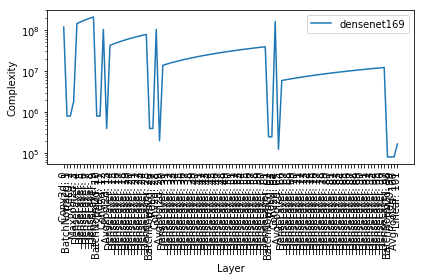

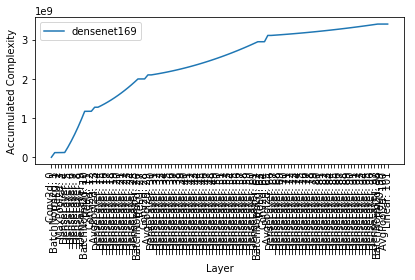

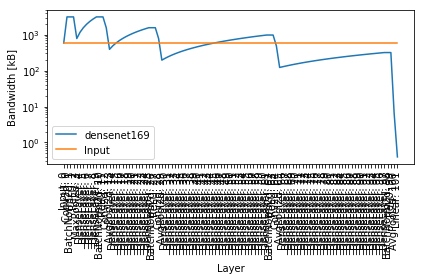

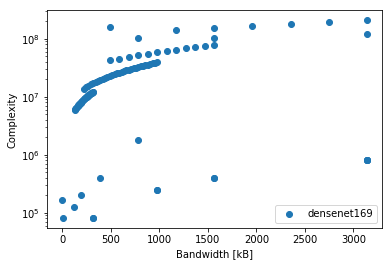

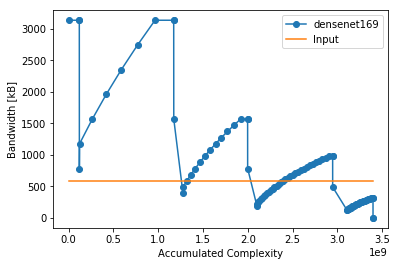

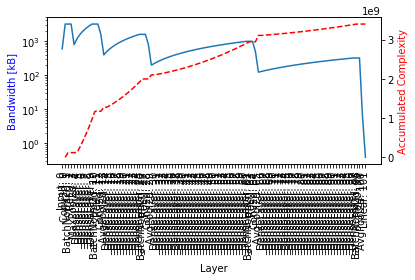

In [9]:
op_count_list, bandwidths, accum_complexities = net_measure_util.compute_model_complexity_and_bandwidth(model, config['model']['type'], (3, 224, 224), scaled=False)